# Setting up Colab environment

In [ ]:
import os
username = 'SkoltechAI'
repo = 'Recommender-Systems-Intro-Sber-2022'

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{username}/{repo}.git

In [ ]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

In [94]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn

from polara import get_movielens_data
from polara.preprocessing.dataframes import reindex, leave_one_out

# navigating to cloned repo directory in Colab
%cd {repo}
from dataprep import transform_indices, matrix_from_data
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items
%cd -

In [95]:
def fix_torch_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Preparing data

In [96]:
mldata = get_movielens_data(include_time=True)

In [97]:
test_timepoint = mldata['timestamp'].quantile(
    q=0.95, interpolation='nearest'
)

In [98]:
test_data_ = mldata.query('timestamp >= @test_timepoint')

In [99]:
test_data_.nunique()

userid         813
movieid       3249
rating           5
timestamp    33729
dtype: int64

In [100]:
train_data_ = mldata.query(
    'userid not in @test_data_.userid.unique() and timestamp < @test_timepoint'
)

In [101]:
training, data_index = transform_indices(train_data_.copy(), 'userid', 'movieid')

In [102]:
test_data = reindex(test_data_, data_index['items'])

Filtered 64 invalid observations.


In [103]:
test_data.nunique()

userid         813
movieid       3220
rating           5
timestamp    33678
dtype: int64

We sample the last item for each test user.  
As all these users are excluded from the training, and training is additionally filtered by timestamp,
there will be no "recommendation from future" issue - our model is unaware of future correlations.


In [104]:
testset_, holdout_ = leave_one_out(
    test_data, target='timestamp', sample_top=True, random_state=0
)
testset_valid_, holdout_valid_ = leave_one_out(
    testset_, target='timestamp', sample_top=True, random_state=0
)

Let's focus on validation part.

In [105]:
userid = data_index['users'].name
test_users = pd.Index(
    # ensure test users are the same across testing data
    np.intersect1d(
        testset_valid_[userid].unique(),
        holdout_valid_[userid].unique()
    )
)
testset_valid = (
    testset_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)
holdout_valid = (
    holdout_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)

In [106]:
testset_valid.nunique()

userid         750
movieid       3202
rating           5
timestamp    32400
dtype: int64

In [107]:
holdout_valid.shape

(750, 4)

In [108]:
assert holdout_valid.set_index('userid')['timestamp'].ge(
    testset_valid
    .groupby('userid')
    ['timestamp'].max()
).all()

In [109]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    order = 'timestamp',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
)
data_description

{'users': 'userid',
 'items': 'movieid',
 'order': 'timestamp',
 'n_users': 5227,
 'n_items': 3652}

# Batch Sampler

In [110]:
def sequential_batch_sampler(user_train, usernum, itemnum, batch_size, maxlen, seed, pad_token=None):
    if pad_token is None:
        pad_token = itemnum
    
    def sample(random_state):
        user = random_state.randint(usernum)
        while len(user_train.get(user, [])) <= 1:
            user = random_state.randint(usernum)
        user_items = user_train[user]
        seq = np.full(maxlen, pad_token, dtype=np.int32)
        pos = np.full(maxlen, pad_token, dtype=np.int32)
        neg = np.full(maxlen, pad_token, dtype=np.int32)
        nxt = user_items[-1]
        idx = maxlen - 1
        ts = set(user_items)
        for i in reversed(user_items[:-1]):
            seq[idx] = i
            pos[idx] = nxt
            neg[idx] = random_neq(0, itemnum, ts, random_state)
            nxt = i
            idx -= 1
            if idx == -1:
                break
        return (user, seq, pos, neg)
    
    random_state = np.random.RandomState(seed)
    while True:
        yield zip(*(sample(random_state) for _ in range(batch_size)))


def random_neq(l, r, s, random_state):
    t = random_state.randint(l, r)
    while t in s:
        t = random_state.randint(l, r)
    return t

# SASRec model

The code is adapted from https://github.com/pmixer/SASRec.pytorch

In [111]:
class PointWiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):

        super(PointWiseFeedForward, self).__init__()

        self.conv1 = nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout2 = nn.Dropout(p=dropout_rate)

    def forward(self, inputs):
        outputs = self.dropout2(self.conv2(self.relu(self.dropout1(self.conv1(inputs.transpose(-1, -2))))))
        outputs = outputs.transpose(-1, -2) # as Conv1D requires (N, C, Length)
        outputs += inputs
        return outputs


class SASRec(nn.Module):
    def __init__(self, item_num, config):
        super(SASRec, self).__init__()
        self.item_num = item_num
        self.pad_token = item_num

        self.item_emb = nn.Embedding(self.item_num+1, config['hidden_units'], padding_idx=self.pad_token)
        self.pos_emb = nn.Embedding(config['maxlen'], config['hidden_units'])
        self.emb_dropout = nn.Dropout(p=config['dropout_rate'])

        self.attention_layernorms = nn.ModuleList() # to be Q for self-attention
        self.attention_layers = nn.ModuleList()
        self.forward_layernorms = nn.ModuleList()
        self.forward_layers = nn.ModuleList()
        self.last_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)

        for _ in range(config['num_blocks']):
            new_attn_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)
            self.attention_layernorms.append(new_attn_layernorm)
            new_attn_layer =  nn.MultiheadAttention(
                config['hidden_units'],config['num_heads'],config['dropout_rate']
            )
            self.attention_layers.append(new_attn_layer)

            new_fwd_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)
            self.forward_layernorms.append(new_fwd_layernorm)

            new_fwd_layer = PointWiseFeedForward(config['hidden_units'], config['dropout_rate'])
            self.forward_layers.append(new_fwd_layer)
        
        fix_torch_seed(config['manual_seed'])
        self.initialize()


    def initialize(self):
        for name, param in self.named_parameters():
            try:
                torch.nn.init.xavier_uniform_(param.data)
            except:
                pass # just ignore those failed init layers


    def log2feats(self, log_seqs):
        device = log_seqs.device
        seqs = self.item_emb(log_seqs)
        seqs *= self.item_emb.embedding_dim ** 0.5
        positions = np.tile(np.arange(log_seqs.shape[1]), [log_seqs.shape[0], 1])
        seqs += self.pos_emb(torch.LongTensor(positions).to(device))
        seqs = self.emb_dropout(seqs)

        timeline_mask = log_seqs == self.pad_token
        seqs *= ~timeline_mask.unsqueeze(-1) # broadcast in last dim

        tl = seqs.shape[1] # time dim len for enforce causality
        attention_mask = ~torch.tril(torch.full((tl, tl), True, device=device))

        for i in range(len(self.attention_layers)):
            seqs = torch.transpose(seqs, 0, 1)
            Q = self.attention_layernorms[i](seqs)
            mha_outputs, _ = self.attention_layers[i](
                Q, seqs, seqs, attn_mask=attention_mask
            )
        
            seqs = Q + mha_outputs
            seqs = torch.transpose(seqs, 0, 1)

            seqs = self.forward_layernorms[i](seqs)
            seqs = self.forward_layers[i](seqs)
            seqs *=  ~timeline_mask.unsqueeze(-1)

        log_feats = self.last_layernorm(seqs) # (U, T, C) -> (U, -1, C)

        return log_feats

    def forward(self, log_seqs, pos_seqs, neg_seqs):
        log_feats = self.log2feats(log_seqs)
        pos_embs = self.item_emb(pos_seqs)
        neg_embs = self.item_emb(neg_seqs)

        pos_logits = (log_feats * pos_embs).sum(dim=-1)
        neg_logits = (log_feats * neg_embs).sum(dim=-1)

        return pos_logits, neg_logits


    def score(self, seq):
        '''
        Takes 1d sequence as input and returns prediction scores.
        '''
        maxlen = self.pos_emb.num_embeddings
        log_seqs = torch.full([maxlen], self.pad_token, dtype=torch.int64, device=seq.device)
        log_seqs[-len(seq):] = seq[-maxlen:]
        log_feats = self.log2feats(log_seqs.unsqueeze(0))
        final_feat = log_feats[:, -1, :] # only use last QKV classifier

        item_embs = self.item_emb.weight
        logits = item_embs.matmul(final_feat.unsqueeze(-1)).squeeze(-1)
        return logits

## Training 

In [112]:
def data_to_sequences(data, data_description):
    userid = data_description['users']
    itemid = data_description['items']
    sequences = (
        data.sort_values([userid, data_description['order']])
        .groupby(userid, sort=False)[itemid].apply(list)
    )
    return sequences

In [113]:
def prepare_sasrec_model(config, data, data_description):
    n_users = data_description['n_users']    
    n_items = data_description['n_items']    
    model = SASRec(n_items, config)
    criterion = torch.nn.BCEWithLogitsLoss()
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()

    train_sequences = data_to_sequences(data, data_description)
    sampler = sequential_batch_sampler(
        train_sequences, n_users, n_items,
        batch_size = config['batch_size'],
        maxlen = config['maxlen'],
        seed = config['sampler_seed'],
        pad_token = model.pad_token
    )
    n_batches = len(train_sequences) // config['batch_size']
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr = config['learning_rate'],
        betas = (0.9, 0.98)
    )
    return model, sampler, n_batches, criterion, optimizer

In [114]:
def train_sasrec_epoch(model, num_batch, l2_emb, sampler, optimizer, criterion, device):
    model.train()
    pad_token = model.pad_token
    losses = []
    for _ in range(num_batch):
        _, *seq_data = next(sampler)
        # convert batch data into torch tensors
        seq, pos, neg = (torch.LongTensor(np.array(x)).to(device) for x in seq_data)
        pos_logits, neg_logits = model(seq, pos, neg)
        pos_labels = torch.ones(pos_logits.shape, device=device)
        neg_labels = torch.zeros(neg_logits.shape, device=device)
        optimizer.zero_grad()
        indices = torch.where(pos != pad_token)
        loss = criterion(pos_logits[indices], pos_labels[indices])
        loss += criterion(neg_logits[indices], neg_labels[indices])
        if l2_emb != 0:
            for param in model.item_emb.parameters():
                loss += l2_emb * torch.norm(param)**2
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [115]:
def build_sasrec_model(config, data, data_description):
    '''Simple MF training routine without early stopping'''
    model, sampler, n_batches, criterion, optimizer = prepare_sasrec_model(config, data, data_description)
    if torch.cuda.is_available():
        device = torch.device(f'cuda:{torch.cuda.current_device()}') 
    losses = {}
    for epoch in tqdm(range(config['num_epochs'])):
        losses[epoch] = train_sasrec_epoch(
            model, n_batches, config['l2_emb'], sampler, optimizer, criterion, device
        )
    return model, losses

In [116]:
config = dict(
    num_epochs = 20,
    maxlen = 200,
    hidden_units = 64,
    dropout_rate = 0.4,
    num_blocks = 1,
    num_heads = 1,
    batch_size = 64,
    sampler_seed = 99,
    manual_seed = 111,
    learning_rate = 1e-3,
    l2_emb = 0,
)

In [117]:
model, losses = build_sasrec_model(config, training, data_description)

100%|██████████| 20/20 [02:03<00:00,  6.18s/it]


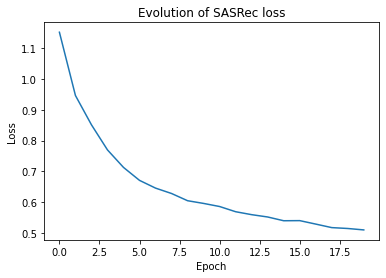

In [118]:
pd.Series(losses).apply(np.mean).plot(title='Evolution of SASRec loss', xlabel='Epoch', ylabel='Loss');

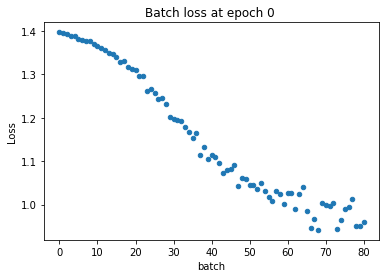

In [119]:
epoch = 0
epoch_loss_series = pd.Series(losses[epoch], name='Loss').rename_axis('batch')
ax = epoch_loss_series.reset_index().plot.scatter(
    x='batch', y='Loss', title=f'Batch loss at epoch {epoch} '
)

# Evaluation

In [120]:
def sasrec_model_scoring(params, data, data_description):
    model = params
    model.eval()
    tensor = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
    test_sequences = data_to_sequences(data, data_description)
    # perform scoring on a user-batch level
    scores = []
    for _, seq in test_sequences.items():
        with torch.no_grad():
            predictions = model.score(tensor(seq))
        scores.append(predictions.detach().cpu().numpy())
    return np.concatenate(scores, axis=0)

In [121]:
sasrec_scores = sasrec_model_scoring(model, testset_valid, data_description)

In [122]:
downvote_seen_items(sasrec_scores, testset_valid, data_description)

In [123]:
sasrec_recs = topn_recommendations(sasrec_scores, topn=10)
model_evaluate(sasrec_recs, holdout_valid, data_description)

(0.076, 0.029858201058201052, 0.261500547645126)

# Baseline check

## PureSVD

In [124]:
from scipy.sparse.linalg import svds

In [125]:
def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_data(data, data_description)
    _, s, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, singular_values

In [126]:
def svd_model_scoring(params, data, data_description):
    item_factors, sigma = params
    n_test_users = data[data_description['users']].nunique()
    test_matrix = matrix_from_data(data, {**data_description, **{'n_users': n_test_users}})
    scores = test_matrix.dot(item_factors) @ item_factors.T
    return scores

In [127]:
def evaluate_svd(params):
    scores = svd_model_scoring(params, testset_valid, data_description)
    downvote_seen_items(scores, testset_valid, data_description)
    recs = topn_recommendations(scores, topn=10)
    return model_evaluate(recs, holdout_valid, data_description)

In [128]:
svd_tuning_ranks = [b*2**i for i in range(3, 10) for b in [2, 3]]
svd_params = build_svd_model(
    {'rank': max(svd_tuning_ranks)},
    training,
    data_description
)
svd_tuning = {}
for rank in tqdm(svd_tuning_ranks):
    # standard model
    item_factors, singvals = svd_params
    rank_params = item_factors[:, :rank], singvals[:rank]
    svd_tuning[rank] = evaluate_svd(rank_params)

100%|██████████| 14/14 [00:02<00:00,  6.15it/s]


In [129]:
svd_results = (
    pd.Series(svd_tuning)
    .apply(pd.Series)
    .rename(columns = ['HR', 'MRR', 'COV'].__getitem__)
)

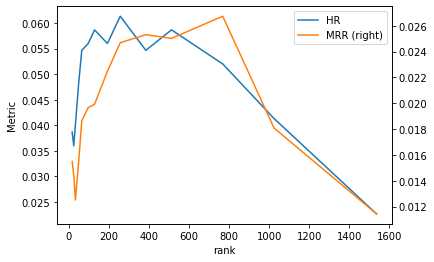

In [130]:
svd_results['HR'].plot(label='HR', legend=True, ylabel='Metric', xlabel='rank')
svd_results['MRR'].plot(secondary_y=True, label='MRR', legend=True);

In [131]:
svd_results.loc[svd_results['HR'].idxmax()]

HR     0.061333
MRR    0.024683
COV    0.256298
Name: 256, dtype: float64